In [ ]:
! pip install kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 93% 309M/331M [00:01<00:00, 219MB/s]
100% 331M/331M [00:01<00:00, 193MB/s]


In [ ]:
import shutil
import cv2
import numpy as np
import os
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import random
import tensorflow as tf
from PIL import ImageEnhance
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 91):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [ ]:
image_dir = "/content/Trial/"
files = os.listdir(image_dir)
size = len(files)
print("Total samples:",size)

Total samples: 4500


In [ ]:
kitty = []
ages = []
genders = []
for filename in files:
    image = cv2.imread(image_dir + filename, 1)
    image = cv2.resize(image,dsize=(224,224))
    kitty.append(image)
    ages.append(filename.split('_')[0])
    genders.append(int(filename.split('_')[1]))
       

In [ ]:
for i in range (50):
    sample = kitty[i]
    cv2_imshow(sample)
    print("Actual Gender:",(genders[i]))

Output hidden; open in https://colab.research.google.com to view.

Total samples: 4500


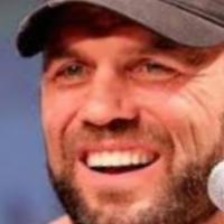

In [ ]:
size_kitty = len(kitty)
size_genders = len(genders)
print("Total samples:",size_kitty)

idx = 204
sample = kitty[idx]
cv2_imshow(sample)

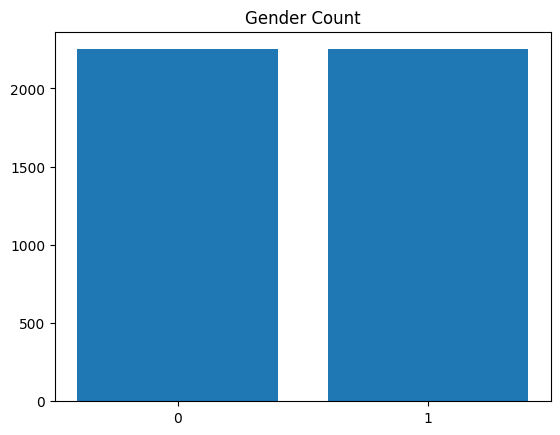

Max value: 1


In [ ]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)
plt.title('Gender Count')
plt.show()
print("Max value:",max(genders))


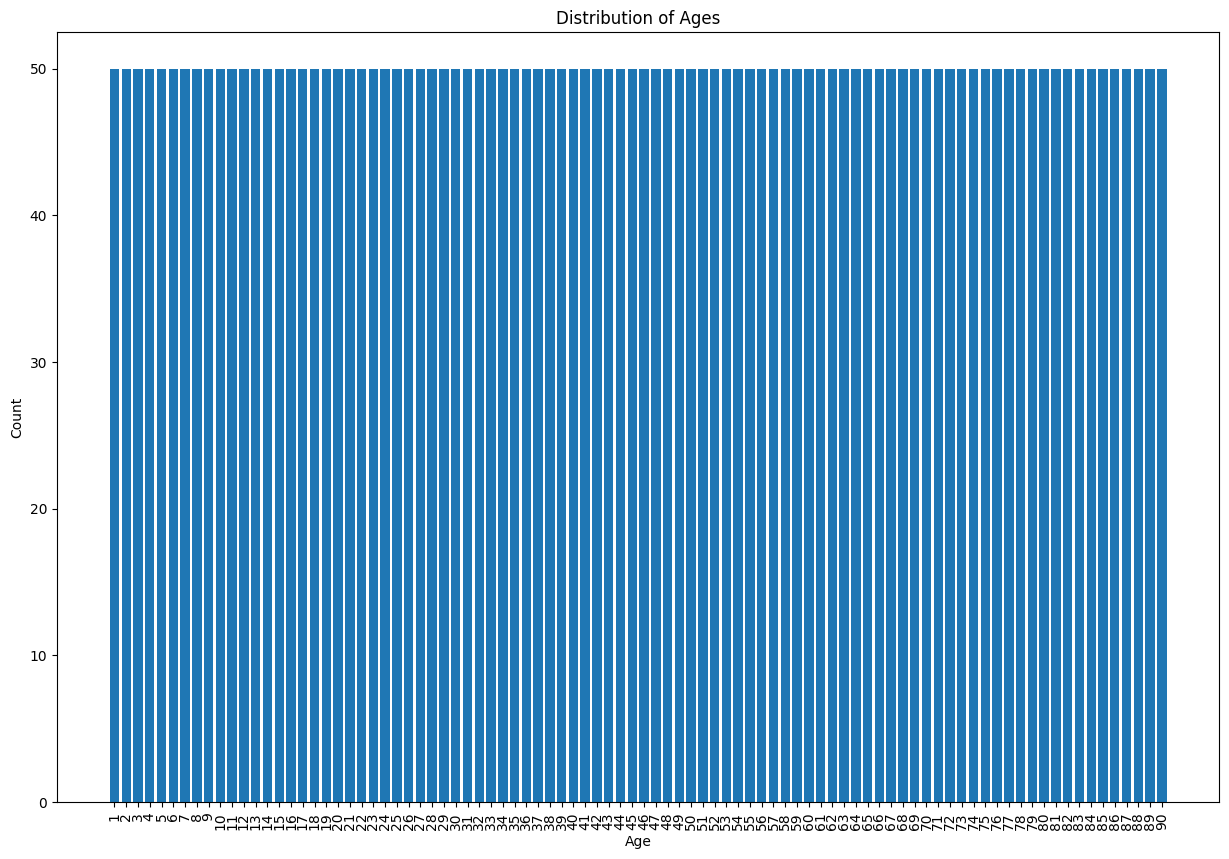

Max value: 90


In [ ]:
# Sort the ages as integers
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)

# Convert sorted integers back to strings with leading zeros
ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

print("Max value:", max(ages))


In [ ]:
target = np.zeros((size_genders,1),dtype='float32')
features = np.zeros((size_kitty,sample.shape[0],sample.shape[1],3),dtype = 'float32')
for i in range(size_kitty):
    target[i, 0] = int(genders[i])
    features[i] = kitty[i]
features = features / 255

In [ ]:
print("target shape ",target.shape)
print("features shape ", features.shape)

target shape  (4500, 1)
features shape  (4500, 224, 224, 3)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)

In [ ]:
print('number of x_train: ', len(x_train))
print('number of y_train: ', len(y_train))
print('number of x_test: ', len(x_test))
print('number of y_test: ', len(y_test))
print('x_train type:', type(x_train))
print('y_train type:', type(y_train))
print('x_test type:', type(x_test))
print('y_test type:', type(y_test))

number of x_train:  3600
number of y_train:  3600
number of x_test:  900
number of y_test:  900
x_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
x_test type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>


In [ ]:
print("x_train shape", x_train.shape)
print("x_test shape", x_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)


x_train shape (3600, 224, 224, 3)
x_test shape (900, 224, 224, 3)
y_train shape (3600, 1)
y_test shape (900, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model

inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
# Add dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       7385

In [ ]:
# avoid overfitting
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=60,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks,
                    verbose=1)


Epoch 1/60
28/29 [===========================>..] - ETA: 0s - loss: 0.8739 - accuracy: 0.5123
Epoch 1: val_loss improved from inf to 0.67725, saving model to best_model.h5
29/29 [==============================] - 9s 230ms/step - loss: 0.8740 - accuracy: 0.5128 - val_loss: 0.6772 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 2/60
28/29 [===========================>..] - ETA: 0s - loss: 0.8144 - accuracy: 0.5098
Epoch 2: val_loss did not improve from 0.67725
29/29 [==============================] - 5s 180ms/step - loss: 0.8139 - accuracy: 0.5097 - val_loss: 0.6882 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 3/60
28/29 [===========================>..] - ETA: 0s - loss: 0.7530 - accuracy: 0.5463
Epoch 3: val_loss improved from 0.67725 to 0.65582, saving model to best_model.h5
29/29 [==============================] - 6s 193ms/step - loss: 0.7525 - accuracy: 0.5464 - val_loss: 0.6558 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 4/60
28/29 [===========================>..] - ETA: 0s - loss: 0.7370 - ac

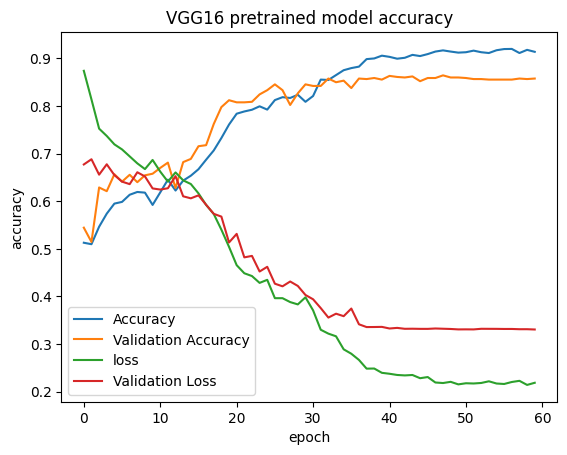

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 pretrained model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:

final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print("Final training accuracy:", final_accuracy)
print("Final validation accuracy:", final_val_accuracy)

Final training accuracy: 0.9138888716697693
Final validation accuracy: 0.8577777743339539


In [ ]:
y_pred = model.predict(x_test)

29/29 [==============================] - 1s 15ms/step


29/29 [==============================] - 1s 20ms/step


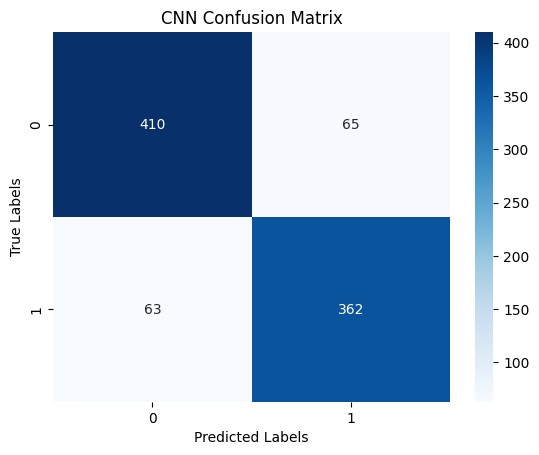

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


29/29 [==============================] - 0s 15ms/step


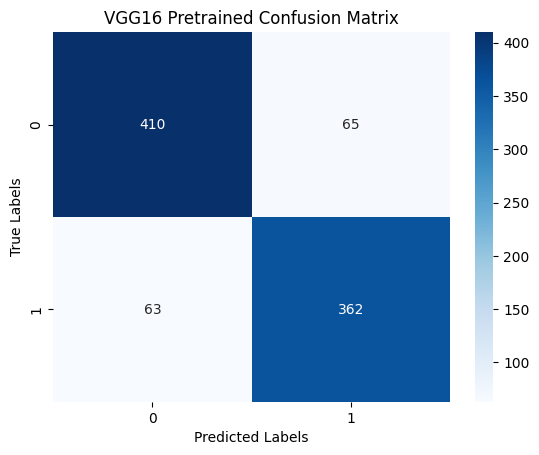

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("VGG16 Pretrained Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
def display(img):
    fig, ax = plt.subplots()
    ax.tick_params(axis='both', which='major', labelsize=0)
    plt.imshow(img[:, :, ::-1])
    plt.show()
    get_result(sample)

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )
    gender = get_gender(val[0][0])
    print("Real    | Predict")
    print(get_gender(genders[i]), " |" , gender)
    print("Prediction Value", val[0][0])
indexes = [900,206,207,5,546,18,48,236,76]
for i in range (50):
    sample = kitty[i]
    display(sample)

Output hidden; open in https://colab.research.google.com to view.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 13.9 MB/s eta 0:00:00


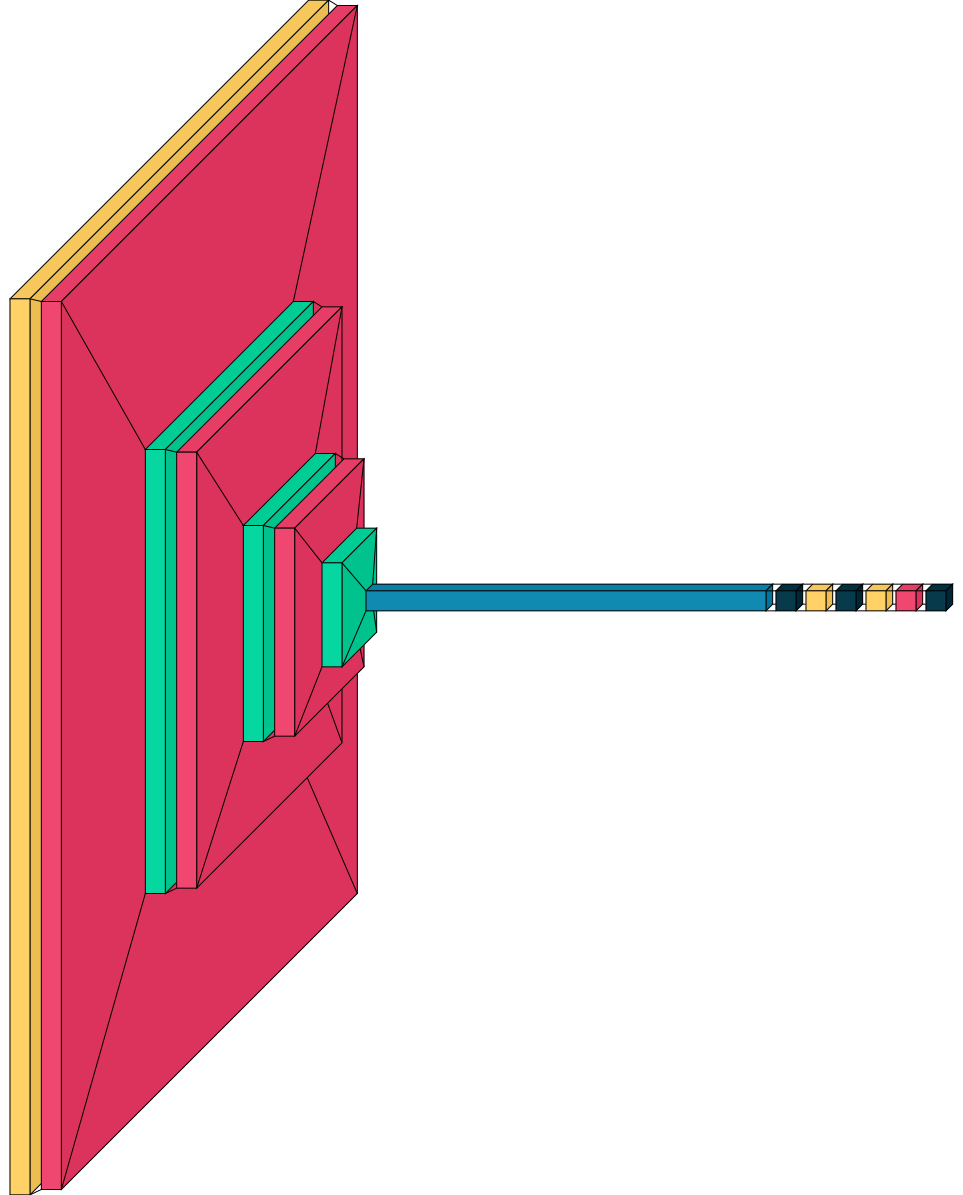

In [ ]:
!pip install visualkeras  
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       7385